In [1]:
import logging
import math
import os
import sys
from typing import Callable, List, Optional, Union
from tqdm import tqdm

import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

from datasets import load_dataset
from torchvision import datasets, transforms
from torchvision.transforms import CenterCrop, Compose, Grayscale, Resize, ToTensor

import pytorch_lightning as pl

from transformers import (
    pipeline, set_seed, 
    AutoModelForSeq2SeqLM, AutoTokenizer, CLIPProcessor, ViTImageProcessor, AutoModel, VisionEncoderDecoderModel,
    BioGptTokenizer, BioGptForCausalLM, GPT2TokenizerFast, BertTokenizer, BlipForConditionalGeneration, BlipProcessor
)

from medpalm.model import MedPalm, MedPalmTokenizer
from medpalm.transformer import AutoregressiveWrapper, Decoder, Encoder, Transformer, ViTransformerWrapper

ROOT = '/ssd003/projects/aieng/public/odyssey/adib_files/'

2024-04-30 15:54:26.478030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 15:54:26.478080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 15:54:26.480015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 15:54:26.491126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 15:54:27.678623: W tensorflow/comp

In [2]:
def process_text(text):
    # Strip leading and trailing whitespaces
    text = text.strip()
    
    # Replace any tab characters with spaces
    text = text.replace('  ', ' ')
    text = text.replace(' \n \n ', ' ')
    text = text.replace('\n ', '\n')
    
    # Replace multiple consecutive newline characters with a single newline
    text = '\n'.join(filter(None, text.split('\n')))
    
    return text.lower()


def process_report(text):
    keywords = ['final report', 'examination', 'indication', 'histoy', 'findings', 'impression', 'comparison', 'exp']
    # Add '\n' before each keyword
    for keyword in keywords:
        text = text.replace(keyword, f'\n{keyword}')
    return text.strip()


def slice_to_period_after_indication(s):
    s = s.lower()

    # Find the starting index of 'indication'
    start_index = s.find('indication')
    if start_index == -1:
        finding_index = s.find('finding')
        return s[finding_index:].strip()
    
    # Find the index of the first '.' after 'indication'
    period_index = s.find('.', start_index)

    if period_index != -1:
        return s[:period_index + 1].strip()

    elif period_index == -1:
        comma_index = s.find(',', start_index)
        return s[:comma_index + 1].strip()

    return s


def load_processor():
    return BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")


def load_checkpoint(path, device):
    checkpoint = torch.load(path)
    state_dict = checkpoint['state_dict']
    state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
    state_dict = {key.replace("vision_", "vision_model."): value for key, value in state_dict.items()}
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    return model


def view_image(pixel_values):
    pixel_values = pixel_values.cpu().numpy()
    plt.imshow(pixel_values.squeeze()[0, :, :], cmap='gray')
    plt.show()


def seed_everything(seed: int) -> None:
    """Seed all components of the model.

    Parameters
    ----------
    seed: int
        Seed value to use

    """
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed)

In [3]:
class config:
    seed = 23
    train_batch_size = 32
    valid_batch_size = 32
    test_batch_size = 1
    num_labels = 2
    num_epochs = 10

seed_everything(config.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph_report_dir = "mimic-data/graph_report_adib.csv"

[rank: 0] Seed set to 23


In [4]:
class MimicIVCXR(Dataset):
    """A PyTorch Dataset for loading image-text pairs from MIMIC-IV-CXR dataset.
    Parameters
    ----------
    graph_report_dir: str
        Path to the csv file containing all paths of the image dataset.
    tokenizer - tokenize text
    max_length - maximum length of the text input
    transform: callable
        Torch transform applied to images.
    """

    def __init__(self,
                 graph_report_dir: str,
                 tokenizer: str,
                 max_length: int,
                 transform: Optional[Callable[[Image.Image], torch.Tensor]] = None,
                ) -> None:
        
        """Initialize the dataset."""
        self.graph_report_dir = graph_report_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

        # load the csv file
        df = pd.read_csv(self.graph_report_dir)
        
        df = df[df["gender"]!= ""]

        # extracts all the radiograph path from the dataset
        self.images_paths = df["radiograph_path"].tolist()

        # extracts all the radiology reports path from the dataset
        self.text_paths = df["radio_report_path"].tolist()

    def __getitem__(self, idx: int) -> Union[int, torch.Tensor, str,str]:
        """Return the image at the specified index."""

        image_path = self.images_paths[idx]
        text_path = self.text_paths[idx]

        # Load image
        # Load the JPEG image
        rgb_image = Image.open(image_path)#.convert('RGB')
        
        # Load text
        with open(text_path, 'r') as file:
            text = process_text(file.read())

        encoding  = self.transform(
            images=rgb_image, 
            text=text,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        encoding.pop('attention_mask')

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        
        return encoding

    def __len__(self) -> int:
        """Return the length of the dataset."""
        return len(self.images_paths)

In [5]:
processor = load_processor()

dataset = MimicIVCXR(
        graph_report_dir=graph_report_dir, 
        tokenizer=None,
        max_length=512,
        transform=processor
    )

print(dataset[23])

{'pixel_values': tensor([[[-1.7193, -1.6755, -1.6901,  ..., -1.6463, -1.6463, -1.6463],
         [-1.7047, -1.6755, -1.7047,  ..., -1.6463, -1.6463, -1.6463],
         [-1.6901, -1.6609, -1.6901,  ..., -1.6463, -1.6463, -1.6463],
         ...,
         [ 1.1712,  1.8135,  1.7114,  ...,  0.5435,  0.4997,  0.4705],
         [ 1.0398,  1.6530,  1.5946,  ...,  0.5289,  0.4997,  0.4413],
         [ 0.9668,  1.6092,  1.5508,  ...,  0.4851,  0.4559,  0.4267]],

        [[-1.6771, -1.6320, -1.6470,  ..., -1.6020, -1.6020, -1.6020],
         [-1.6621, -1.6320, -1.6621,  ..., -1.6020, -1.6020, -1.6020],
         [-1.6470, -1.6170, -1.6470,  ..., -1.6020, -1.6020, -1.6020],
         ...,
         [ 1.2945,  1.9548,  1.8498,  ...,  0.6491,  0.6041,  0.5741],
         [ 1.1594,  1.7897,  1.7297,  ...,  0.6341,  0.6041,  0.5441],
         [ 1.0844,  1.7447,  1.6847,  ...,  0.5891,  0.5591,  0.5291]],

        [[-1.4091, -1.3665, -1.3807,  ..., -1.3380, -1.3380, -1.3380],
         [-1.3949, -1.3665, 

In [6]:
model = load_checkpoint(f'{ROOT}/model_Epepoch=1.ckpt', device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
# ##### EVALUATION #####
# # Generate a list of random indices from the dataset
# random_datapoints = random.sample(range(len(dataset)), 10000)
# random_datapoints = random_datapoints[5000:]
# output_dir = 'predictions.csv'

# # Initialize buffer
# buffer = []
# buffer_size = 500

# for i, example_id in tqdm(enumerate(random_datapoints), unit=' datapoint', desc='Generating Reports'):
#     my_image = dataset.images_paths[example_id]
#     my_text = dataset.text_paths[example_id]
#     text = open(my_text, 'r').read()
#     text_prompt = slice_to_period_after_indication(text)

#     # Process the inputs
#     inputs = processor(
#         images=Image.open(my_image), 
#         text=text_prompt,
#         padding="do_not_pad",
#         truncation=True,
#         return_tensors="pt"
#     )

#     # Generate an entire radiology report
#     output = model.generate(
#         input_ids=inputs['input_ids'].to(device), 
#         pixel_values=inputs['pixel_values'].to(device),
#         max_length=512
#     )
#     report = processor.decode(output[0], skip_special_tokens=True)

#     # Append the data to the buffer
#     buffer.append({
#         "id": example_id,
#         "prompt": text_prompt,
#         "original_report": text,
#         "predicted_report": report
#     })

#     # Check if buffer has reached its size limit and write to disk
#     if len(buffer) >= buffer_size:
#         buffer_df = pd.DataFrame(buffer)
#         buffer_df.to_csv(output_dir, mode='a', header=not os.path.exists(output_dir), index=False)
#         buffer = []  # Reset the buffer

# # Write any remaining data in the buffer to disk
# if buffer:
#     buffer_df = pd.DataFrame(buffer)
#     buffer_df.to_csv(output_dir, mode='a', header=not os.path.exists(output_dir), index=False)

In [8]:
# Example Data | 603, 128
example = 12516
my_image = dataset.images_paths[example]
my_text = dataset.text_paths[example]
text = process_text(open(my_text, 'r').read())
text_prompt = slice_to_period_after_indication(text)

# process the inputs
inputs = processor(
    images=Image.open(my_image), 
    text=text_prompt,
    padding="do_not_pad",
    return_tensors="pt"
)
labels = processor(
    text=text,
    return_tensors="pt"
).input_ids
inputs["labels"] = labels

# Alternatively
inputs = {k: v.to(device) for k, v in inputs.items()}

# generate an entire radiology report
output = model.generate(
    input_ids=inputs['input_ids'], 
    pixel_values=inputs['pixel_values'],
    max_length=512
)
report = processor.decode(output[0], skip_special_tokens=True)
report = process_report(report)

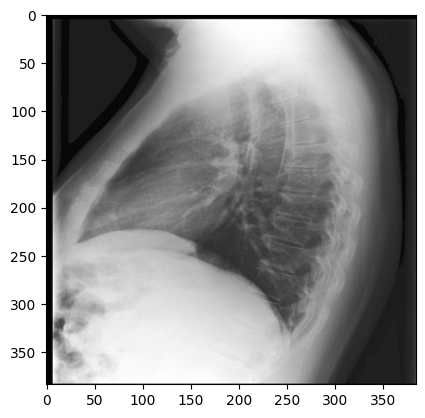

In [9]:
# View Image
pixel_values = inputs['pixel_values'].cpu().numpy()
plt.close('all')
plt.imshow(pixel_values.squeeze()[0, :, :], cmap='gray')
plt.show()

In [10]:
print(f'ORIGINAL REPORT:\n\n{text}')

ORIGINAL REPORT:

final report
chest two views: ___ history: ___-year-old male with chest pain on the left.
findings: frontal and lateral views of the chest. no prior. the lungs are
clear. there is no pneumothorax. cardiomediastinal silhouette is within
normal limits. hypertrophic changes seen in the spine. osseous and soft
tissue structures are otherwise unremarkable.
impression: no acute cardiopulmonary process.


In [12]:
print(f'PREDICTED REPORT:\n\n{report}')

PREDICTED REPORT:

findings : frontal and lateral views of the chest. no prior. the lungs are clear. there is no pneumothorax. cardiomediastinal silhouette is within normal limits. hypertrophic changes seen in the spine. osseous and soft tissue structures are otherwise unremarkable. 
impression : no acute cardiopulmonary process.
